<a href="https://colab.research.google.com/github/maria-papz/final-year-project/blob/main/LSTM_price_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data from yahoo finance

In [ ]:
 !pip install pandas_ta
# Import the library
import yfinance as yf
import pandas_ta as ta
import pandas as pd



# Define the start and end dates (replace with your desired dates)
start_date = "2008-01-01"
end_date = "2024-02-09"

# Download the S&P 500 data
sp500 = yf.download("^GSPC", start=start_date, end=end_date)
print(sp500.head())

# print(sp500.head())
# help(ta.bbands)

indicators_df = pd.DataFrame({"Close": sp500["Close"]})


[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-02  1467.969971  1471.770020  1442.069946  1447.160034  1447.160034   
2008-01-03  1447.550049  1456.800049  1443.729980  1447.160034  1447.160034   
2008-01-04  1444.010010  1444.010010  1411.189941  1411.630005  1411.630005   
2008-01-07  1414.069946  1423.869995  1403.449951  1416.180054  1416.180054   
2008-01-08  1415.709961  1430.280029  1388.300049  1390.189941  1390.189941   

                Volume  
Date                    
2008-01-02  3452650000  
2008-01-03  3429500000  
2008-01-04  4166000000  
2008-01-07  4221260000  
2008-01-08  4705390000  


calculating indicators

In [ ]:
# Trend-following indicators


indicators_df["sma5"] = ta.sma(sp500["Close"], length=5)
indicators_df['Close']=sp500['Close']
indicators_df["sma10"] = ta.sma(sp500["Close"], length=10)


indicators_df["ema12"] = ta.ema(sp500["Close"],length=12)


indicators_df["rdp5"]=sp500["Close"].pct_change(5) * 100
indicators_df["rdp10"]=sp500["Close"].pct_change(10) * 100

indicators_df["atr"]= ta.atr(sp500["High"],sp500["Low"],sp500["Close"])

## Momentum Indicators 14, 21, or 28
# help(ta.rsi)
indicators_df["rsi14"] = ta.rsi(sp500["Close"], length=14)
indicators_df["mom"] = ta.mom(sp500["Close"],length=1)
print(indicators_df.head())


                  Close         sma5  sma10  ema12  rdp5  rdp10  atr  rsi14  \
Date                                                                          
2008-01-02  1447.160034          NaN    NaN    NaN   NaN    NaN  NaN    NaN   
2008-01-03  1447.160034          NaN    NaN    NaN   NaN    NaN  NaN    NaN   
2008-01-04  1411.630005          NaN    NaN    NaN   NaN    NaN  NaN    NaN   
2008-01-07  1416.180054          NaN    NaN    NaN   NaN    NaN  NaN    NaN   
2008-01-08  1390.189941  1422.464014    NaN    NaN   NaN    NaN  NaN    NaN   

                  mom  
Date                   
2008-01-02        NaN  
2008-01-03   0.000000  
2008-01-04 -35.530029  
2008-01-07   4.550049  
2008-01-08 -25.990112  


In [ ]:
indicators_df.dropna(inplace=True)
print(indicators_df.head())

                  Close         sma5        sma10        ema12      rdp5  \
Date                                                                       
2008-01-23  1338.599976  1336.147974  1370.841980  1373.007661 -3.066728   
2008-01-24  1352.069946  1331.921973  1365.135974  1369.786474 -1.538742   
2008-01-25  1330.609985  1331.393970  1356.163977  1363.759322 -0.198013   
2008-01-28  1353.959961  1337.147974  1351.457971  1362.251728  2.171011   
2008-01-29  1362.300049  1347.507983  1346.062976  1362.259162  3.952694   

               rdp10        atr      rsi14        mom  
Date                                                   
2008-01-23 -3.711001  37.712027  31.522748  28.099976  
2008-01-24 -4.049311  35.915912  36.710299  13.469971  
2008-01-25 -6.316840  36.445000  32.487681 -21.459961  
2008-01-28 -3.358985  35.972827  40.506421  23.349976  
2008-01-29 -3.809352  33.913775  43.105744   8.340088  


split the data

In [ ]:
# Split the data into training and testing sets chronologically
split_index = int(len(indicators_df) * 0.8)  # Use 80% of data for training, 20% for testing
train_df = indicators_df.iloc[:split_index]
test_df = indicators_df.iloc[split_index:]

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()
scaler = scaler.fit(train_df)
df_scaled = scaler.transform(train_df)

looking forward


In [ ]:
import numpy as np
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_scaled) - n_future +1):
    trainX.append(df_scaled[i - n_past:i, 0:train_df.shape[1]])
    trainY.append(df_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3218, 14, 9).
trainY shape == (3218, 1).


Predicting

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18944     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31393 (122.63 KB)
Trainable params: 31393 (122.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
181/181 [==============================] - 12s 26ms/step - loss: 0.0738 - val_loss: 0.1753
Epoch 2/50
181/181 [============================

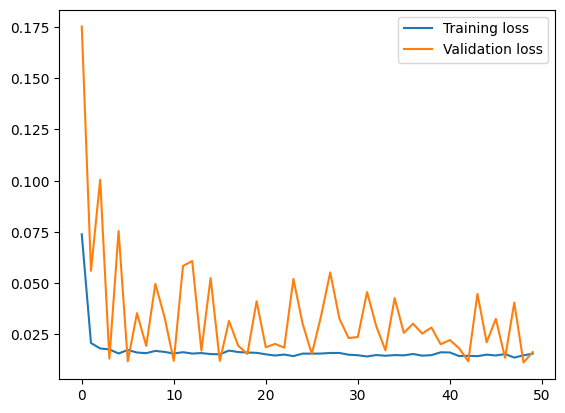

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Evaluate on test set

25/25 [==============================] - 1s 6ms/step
RMSE: 80.67189044571316
R^2: 0.9309894989834796


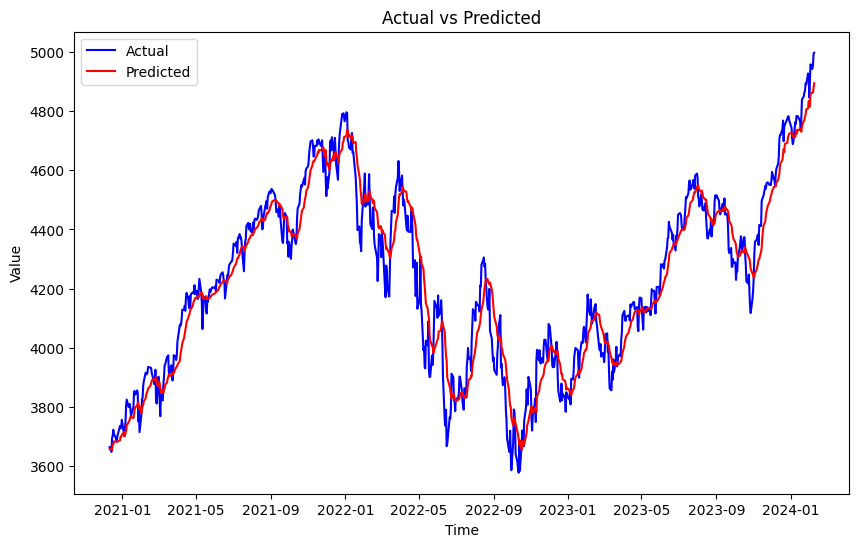

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


scaler = StandardScaler()
scaler = scaler.fit(test_df)
df_scaled = scaler.transform(test_df)
# Make predictions on the test data
testX = []
testY = []

# Similar to the training data, create test sequences for testX and testY
for i in range(n_past, len(test_df) - n_future + 1):
    testX.append(df_scaled[i - n_past:i, 0:test_df.shape[1]])
    testY.append(df_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

# Make predictions
predictions = model.predict(testX)

# Inverse transform the predictions to get the original scale
predictions = scaler.inverse_transform(np.repeat(predictions, train_df.shape[1], axis=-1))[:,0]

# Get the true values from the test data
true_values = test_df.iloc[n_past + n_future - 1:, 0].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_values, predictions))
print("RMSE:", rmse)

# Calculate R^2
r2 = r2_score(true_values, predictions)
print("R^2:", r2)

import matplotlib.pyplot as plt


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df.index[n_past + n_future - 1:], true_values, label='Actual', color='blue')
plt.plot(test_df.index[n_past + n_future - 1:], predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()




feature selection based on model

Model looks quite decent with no optimisation etc. , but really it's not! If i were to use a trading stategy where I calculate returns based on the price predicted let's see how i would do, it's quite bad

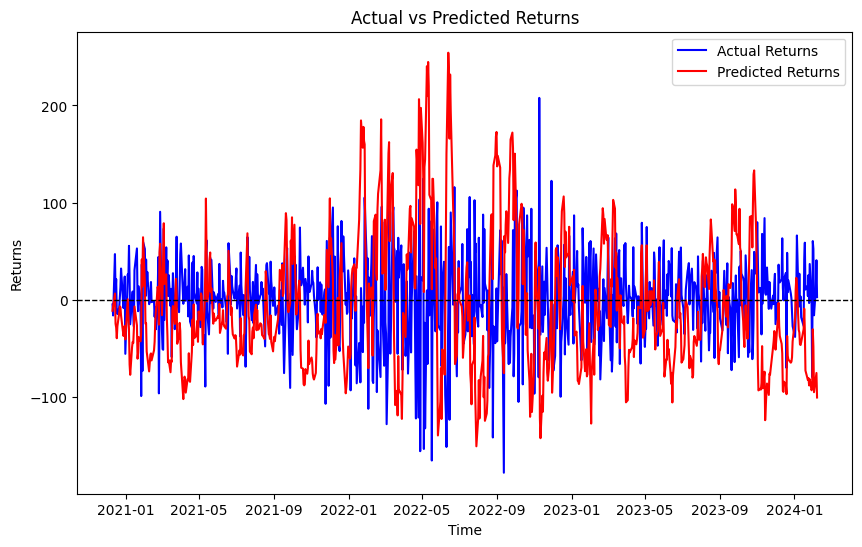

In [ ]:
# Calculate returns for both actual and predicted values
actual_returns = true_values - test_df.iloc[n_past + n_future - 2:-1, 0].values
predicted_returns = predictions - test_df.iloc[n_past + n_future - 2:-1, 0].values

# Plot actual vs predicted returns
plt.figure(figsize=(10, 6))
plt.plot(test_df.index[n_past + n_future - 2:-1], actual_returns, label='Actual Returns', color='blue')
plt.plot(test_df.index[n_past + n_future - 2:-1], predicted_returns, label='Predicted Returns', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0 for reference
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()


In [ ]:
import random

random_month_start = random.choice(range(len(test_df) - n_past - n_future))
random_month_end = random_month_start + 30  # Assuming a month is 30 days


actual_returns_month = actual_returns[random_month_start:random_month_end]
predicted_returns_month = predicted_returns[random_month_start:random_month_end]

positive_returns_mask_month = predicted_returns_month > 0

potential_gains_month = actual_returns_month[positive_returns_mask_month]
potential_losses_month = actual_returns_month[~positive_returns_mask_month]


predicted_gains_month = predicted_returns_month[positive_returns_mask_month]

print(predicted_returns_month[positive_returns_mask_month])
total_gain_month = potential_gains_month.sum()
total_predicted_month = predicted_gains_month.sum()






print(f"Actual gain based on predicted positive returns in the selected month: {total_gain_month:.2f}")

print(f"Predicted gain: {total_predicted_month:.2f}")



[ 16.24658203  12.30615234  17.02832031  46.87695312  98.39648438
  95.95361328  70.94433594 113.68554688 100.43359375  67.56347656
  67.34667969  57.33789062  93.73486328  53.66650391  49.92773438
   2.45214844  16.58056641  45.76611328  85.47998047  86.39355469
  54.02734375]
Actual gain based on predicted positive returns in the selected month: -242.49
Predicted gain: 1252.15


might be less informative than a graph, but demostrates that lstm price prediction can be decieving

And let's show that even if we were using returns as a predictor, the timeseries is too complex for an lstm to capture its patterns, and make predictions

trainX shape == (3217, 14, 9).
trainY shape == (3217, 1).
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            18944     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31393 (122.63 KB)
Trainable params: 31393 (122.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
181/181 [==============================] - 7s 18ms/step - loss: 0.8825 - val_lo

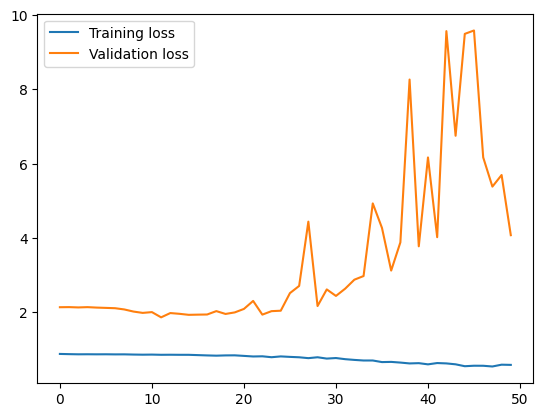

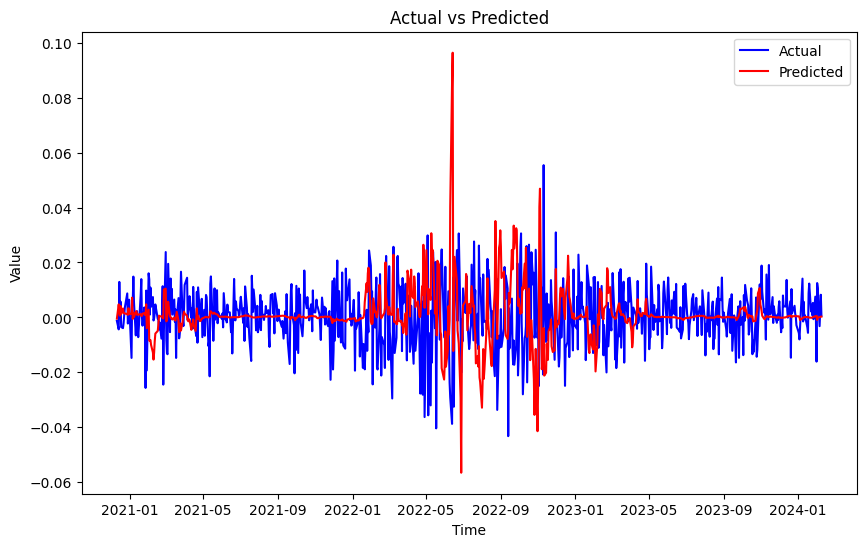

In [ ]:
indicators_df["Close"]= indicators_df['Close'].pct_change()
indicators_df = indicators_df.rename(columns={'Close': 'Returns'})
indicators_df.dropna(inplace=True)
# Split the data into training and testing sets chronologically
split_index = int(len(indicators_df) * 0.8)  # Use 80% of data for training, 20% for testing
train_df = indicators_df.iloc[:split_index]
test_df = indicators_df.iloc[split_index:]
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()
scaler = scaler.fit(train_df)
df_scaled = scaler.transform(train_df)

import numpy as np
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_scaled) - n_future +1):
    trainX.append(df_scaled[i - n_past:i, 0:train_df.shape[1]])
    trainY.append(df_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()



from sklearn.metrics import mean_squared_error, r2_score


scaler = StandardScaler()
scaler = scaler.fit(test_df)
df_scaled = scaler.transform(test_df)
# Make predictions on the test data
testX = []
testY = []

# Similar to the training data, create test sequences for testX and testY
for i in range(n_past, len(test_df) - n_future + 1):
    testX.append(df_scaled[i - n_past:i, 0:test_df.shape[1]])
    testY.append(df_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

# Make predictions
predictions = model.predict(testX)

# Inverse transform the predictions to get the original scale
predictions = scaler.inverse_transform(np.repeat(predictions, train_df.shape[1], axis=-1))[:,0]

# Get the true values from the test data
true_values = test_df.iloc[n_past + n_future - 1:, 0].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_values, predictions))
print("RMSE:", rmse)

# Calculate R^2
r2 = r2_score(true_values, predictions)
print("R^2:", r2)

import matplotlib.pyplot as plt


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df.index[n_past + n_future - 1:], true_values, label='Actual', color='blue')
plt.plot(test_df.index[n_past + n_future - 1:], predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()




